In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt # to show graphical results
import re

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# own modules
import modules.config as config
from modules.load_model import load_model
from modules.load_predict_data import load_predict_data

In [3]:
# set constants
MODEL_NAME = re.search(r"\/([A-Za-z0-9_-]{1,})\.zip", config.TRAINED_MODEL)
PICTURE_SIZE = re.search(r"([0-9]{1,})_([0-9]{1,})\.zip", config.TRAINED_MODEL)

In [4]:
model, label = load_model(config.TRAINED_MODEL)

In [5]:
predict_me, predict_file, predict_file_name = load_predict_data(config.PREDICT_DATA, int(PICTURE_SIZE.group(1)), int(PICTURE_SIZE.group(2)))
len(predict_me)

11

In [6]:
model

In [7]:
label

{'Cat': 0, 'Dog': 1}

In [8]:
prob_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [9]:
predictions = prob_model.predict(predict_me)

In [10]:
predictions[0]

array([0.5448739 , 0.45512617], dtype=float32)

In [11]:
len(label)

2

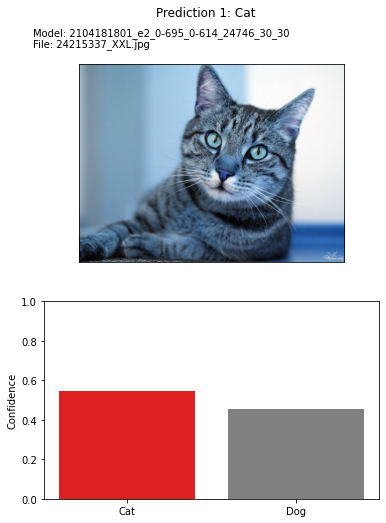

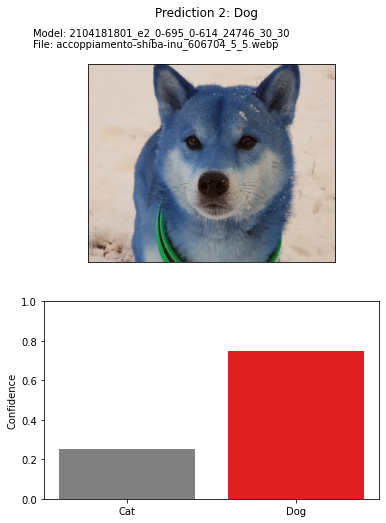

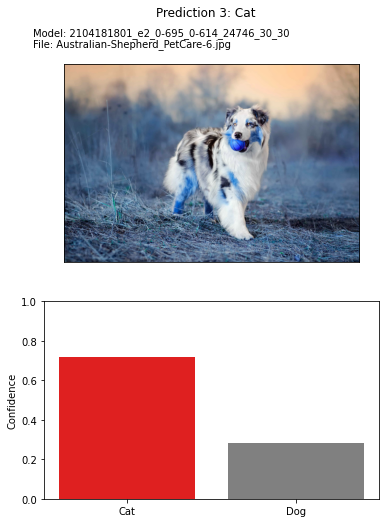

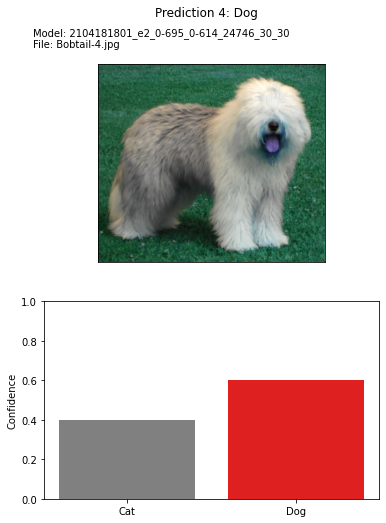

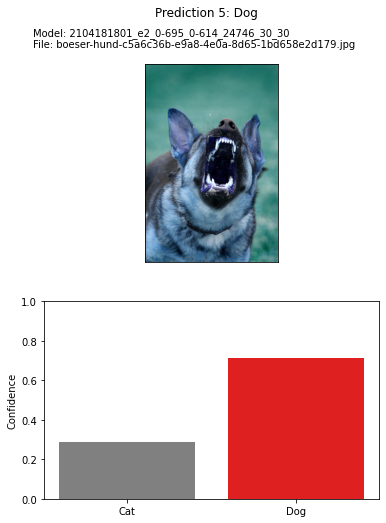

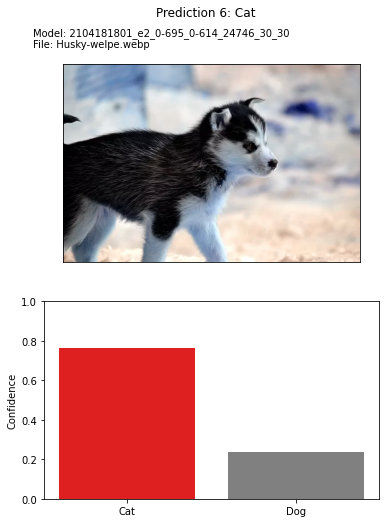

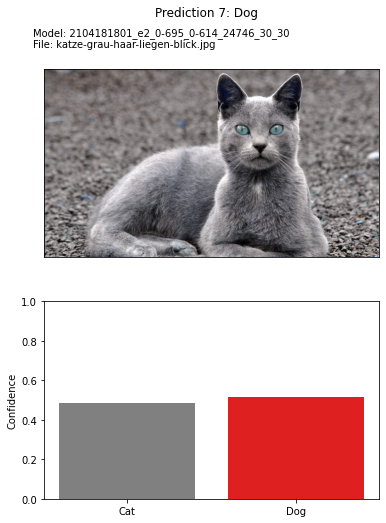

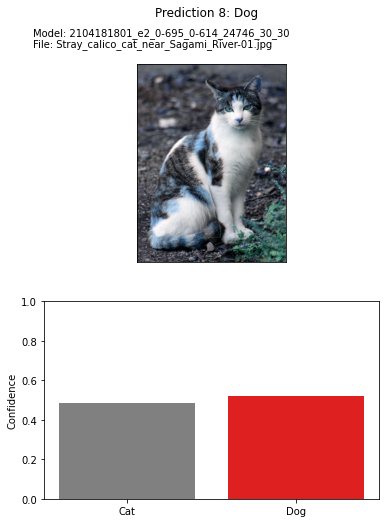

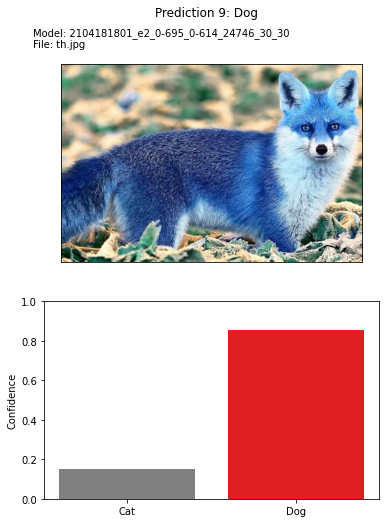

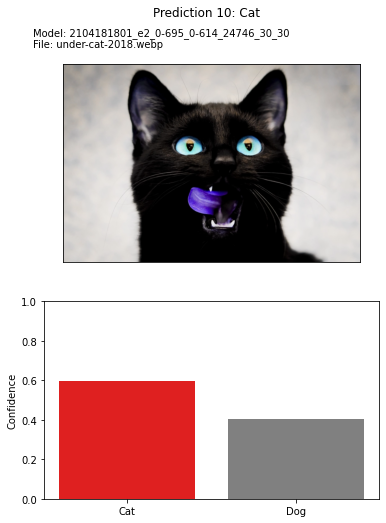

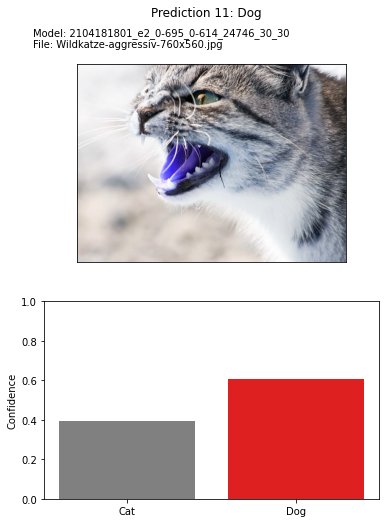

In [12]:
for i in range(len(predict_me)):
    fig = plt.figure(figsize=(6, 8), facecolor="white")    
    fig.suptitle(f"Prediction {i+1}: {list(label.keys())[list(label.values()).index(predictions[i].argmax())]}\n")
    fig.text(0.1, 0.93, f"Model: {MODEL_NAME.group(1)}")
    fig.text(0.1, 0.91, f"File: {predict_file_name[i]}")
    
    pic = fig.add_subplot(2,1,1)
    pic.axes.xaxis.set_ticks([])
    pic.axes.yaxis.set_ticks([])
    pic.imshow(predict_file[i])
    
    colrs = []
    for j in range(len(label)):
        if j == predictions[i].argmax():
            colrs.append("#DF2020")
        else:
            colrs.append("grey")
    
    hist = fig.add_subplot(2,1,2)
    hist.bar(list(label.keys()), predictions[i], color=colrs)
    hist.set_ylabel("Confidence")
    hist.set_ylim([0,1])